In [1]:
!pip install git+https://github.com/tczhangzhi/torcheeg.git

  Cloning https://github.com/tczhangzhi/torcheeg.git to /tmp/pip-req-build-lig1aa51
  Running command git clone --filter=blob:none --quiet https://github.com/tczhangzhi/torcheeg.git /tmp/pip-req-build-lig1aa51
  Resolved https://github.com/tczhangzhi/torcheeg.git to commit b6def3ab295fc9df9fc5dce495634e639def398b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.8/230.8 kB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Loading data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_path = '/content/drive/MyDrive/NMA2023_DL/Stroke_Dataset'
data_path = f'{base_path}/mi_channels/'

In [5]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import numpy as np

class EEGDataset(Dataset):
    def __init__(self, data_folder_path: str, subjects: list, shuffle: bool = True):
      """
      `data_folder_path` should have following structure:
        - subject001.npz
        - subject001.npz
        ...

      Each npz file contains both "data" and "labels" for one subject.
      """

      print("----")
      print(f"Creating dataset for {len(subjects)} subjects...")
      data_list = []
      labels_list = []

      for i in subjects:
        data_and_labels = np.load(f"{data_folder_path}/subject{i:03}.npz")

        data = data_and_labels['data']
        data = data.reshape((data.shape[0], 1, *data.shape[1:])) # N C W -> N 1 C W

        labels = data_and_labels['labels']
        data_list.append(data)
        labels_list.append(labels)

      self.data = torch.tensor(np.concatenate(data_list).astype(np.float32))
      self.labels = torch.tensor(np.concatenate(labels_list).astype(np.long))

      if shuffle:
        idx = torch.randperm(self.data.shape[0])
        self.data = self.data[idx]
        self.labels = self.labels[idx]

      print("Dataset created:")
      print("Data shape:", self.data.shape)
      print("Labels shape:", self.labels.shape)
      print("----")


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [ ]:
from torch.utils.data import random_split

NUMBER_OF_SUBJECTS = len([name for name in os.listdir(data_path) if name.endswith("npz")])
print("NUMBER_OF_SUBJECTS:", NUMBER_OF_SUBJECTS)

subjects = range(1, NUMBER_OF_SUBJECTS)

split_size = [0.6, 0.2, 0.2]

splits = random_split(subjects, split_size)
train_subjects = list(splits[0])
val_subjects = list(splits[1])
test_subjects = list(splits[2])

NUMBER_OF_SUBJECTS: 50


In [ ]:
train_data = EEGDataset(data_path, train_subjects, shuffle=True)
val_data = EEGDataset(data_path, val_subjects, shuffle=True)
test_data = EEGDataset(data_path, test_subjects, shuffle=True)

----
Creating dataset for 30 subjects...


<ipython-input-5-1ffc25a616b2>:34: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels = torch.tensor(np.concatenate(labels_list).astype(np.long))


Dataset created:
Data shape: torch.Size([2400, 1, 19, 640])
Labels shape: torch.Size([2400])
----
----
Creating dataset for 10 subjects...
Dataset created:
Data shape: torch.Size([800, 1, 19, 640])
Labels shape: torch.Size([800])
----
----
Creating dataset for 9 subjects...
Dataset created:
Data shape: torch.Size([720, 1, 19, 640])
Labels shape: torch.Size([720])
----


In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

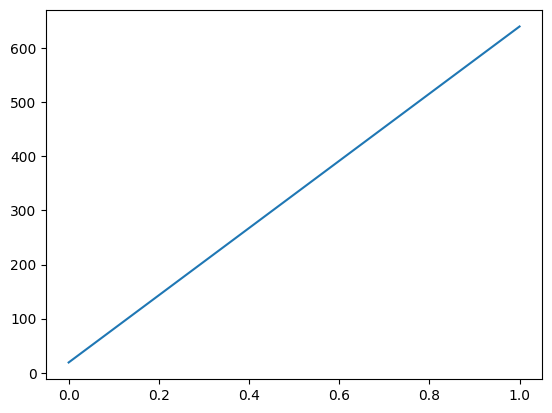

In [ ]:
import matplotlib.pyplot as plt

for i, ix in enumerate(train_loader):
  plt.plot(ix[0][0][0])
  break

#Load the pre-trained model

In [ ]:
model_path = '/content/drive/MyDrive/NMA2023_DL/Trained_model.pth'
model = torch.load(model_path)
model.eval()

ClassifierTrainer(
  (model): EEGNet(
    (block1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(1, 128), stride=(1, 1), padding=(0, 64), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Conv2dWithConstraint(64, 128, kernel_size=(19, 1), stride=(1, 1), groups=64, bias=False)
      (3): BatchNorm2d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (4): ELU(alpha=1.0)
      (5): AvgPool2d(kernel_size=(1, 4), stride=4, padding=0)
      (6): Dropout(p=0.4, inplace=False)
    )
    (block2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(1, 8), stride=(1, 1), padding=(0, 4), groups=128, bias=False)
      (1): Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(4, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (3): ELU(alpha=1.0)
      (4): AvgPool2d(kernel_size=(1, 8), stride=8, padding=0)
      (5): Dropout(p=0.4, inplace=False)
   

In [ ]:
model.test(train_loader)
model.test(val_loader)
model.test(test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


[Test] test_loss: 1.204 test_accuracy: 0.501 



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5008333325386047     │
│         test_loss         │    1.2037767171859741     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


[Test] test_loss: 1.123 test_accuracy: 0.530 



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5299999713897705     │
│         test_loss         │    1.1228686571121216     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


[Test] test_loss: 1.167 test_accuracy: 0.494 



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.49444442987442017    │
│         test_loss         │    1.1667416095733643     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.1667416095733643, 'test_accuracy': 0.49444442987442017}]

#Train only classification layer

In [ ]:
for name, param in model.named_parameters():
    if 'lin' not in name:
        print(name, param.requires_grad)
        param.requires_grad=False


model.block1.0.weight True
model.block1.1.weight True
model.block1.1.bias True
model.block1.2.weight True
model.block1.3.weight True
model.block1.3.bias True
model.block2.0.weight True
model.block2.1.weight True
model.block2.2.weight True
model.block2.2.bias True


In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)


model.block1.0.weight False
model.block1.1.weight False
model.block1.1.bias False
model.block1.2.weight False
model.block1.3.weight False
model.block1.3.bias False
model.block2.0.weight False
model.block2.1.weight False
model.block2.2.weight False
model.block2.2.bias False
model.lin.weight True


In [ ]:
model.configure_optimizers(torch.optim.Adam(model.parameters(), lr = 1e-5))
model.fit(train_loader, val_loader, max_epochs = 150)

TypeError: ignored

In [ ]:
model.test(train_loader)
model.test(val_loader)
model.test(test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


[Test] test_loss: 0.685 test_accuracy: 0.545 



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5450000166893005     │
│         test_loss         │    0.6847591400146484     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


[Test] test_loss: 0.700 test_accuracy: 0.500 



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │            0.5            │
│         test_loss         │    0.7001612782478333     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


[Test] test_loss: 0.696 test_accuracy: 0.518 



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5180555582046509     │
│         test_loss         │    0.6958379745483398     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6958379745483398, 'test_accuracy': 0.5180555582046509}]

#Fine Tuning

In [ ]:
model_path = '/content/drive/MyDrive/NMA2023_DL/Trained_model.pth'
model = torch.load(model_path)

In [ ]:
model.fit(train_loader, val_loader, max_epochs = 150)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | EEGNet           | 12.7 K
1 | _ce_fn        | CrossEntropyLoss | 0     
2 | train_loss    | MeanMetric       | 0     
3 | val_loss      | MeanMetric       | 0     
4 | test_loss     | MeanMetric       | 0     
5 | train_metrics | MetricCollection | 0     
6 | val_metrics   | MetricCollection | 0     
7 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
12.7 K    Trainable params


Sanity Checking: 0it [00:00, ?it/s]


[Val] val_loss: 1.210 val_accuracy: 0.469 



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.783 val_accuracy: 0.524 


[Train] train_loss: 1.164 train_accuracy: 0.491 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.734 val_accuracy: 0.510 


[Train] train_loss: 0.864 train_accuracy: 0.524 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.751 val_accuracy: 0.505 


[Train] train_loss: 0.791 train_accuracy: 0.505 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.725 val_accuracy: 0.511 


[Train] train_loss: 0.737 train_accuracy: 0.541 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.915 val_accuracy: 0.505 


[Train] train_loss: 0.722 train_accuracy: 0.536 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.767 val_accuracy: 0.506 


[Train] train_loss: 0.713 train_accuracy: 0.539 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.779 val_accuracy: 0.505 


[Train] train_loss: 0.707 train_accuracy: 0.538 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.764 val_accuracy: 0.498 


[Train] train_loss: 0.697 train_accuracy: 0.546 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.737 val_accuracy: 0.507 


[Train] train_loss: 0.700 train_accuracy: 0.525 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.720 val_accuracy: 0.499 


[Train] train_loss: 0.688 train_accuracy: 0.545 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.721 val_accuracy: 0.501 


[Train] train_loss: 0.681 train_accuracy: 0.554 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.481 


[Train] train_loss: 0.691 train_accuracy: 0.546 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.484 


[Train] train_loss: 0.679 train_accuracy: 0.572 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.731 val_accuracy: 0.499 


[Train] train_loss: 0.669 train_accuracy: 0.582 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.712 val_accuracy: 0.517 


[Train] train_loss: 0.676 train_accuracy: 0.568 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.734 val_accuracy: 0.504 


[Train] train_loss: 0.670 train_accuracy: 0.571 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.729 val_accuracy: 0.501 


[Train] train_loss: 0.670 train_accuracy: 0.568 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.709 val_accuracy: 0.506 


[Train] train_loss: 0.672 train_accuracy: 0.582 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.715 val_accuracy: 0.496 


[Train] train_loss: 0.663 train_accuracy: 0.582 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.713 val_accuracy: 0.517 


[Train] train_loss: 0.667 train_accuracy: 0.575 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.721 val_accuracy: 0.506 


[Train] train_loss: 0.667 train_accuracy: 0.585 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.718 val_accuracy: 0.512 


[Train] train_loss: 0.671 train_accuracy: 0.573 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.740 val_accuracy: 0.496 


[Train] train_loss: 0.662 train_accuracy: 0.591 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.709 val_accuracy: 0.493 


[Train] train_loss: 0.661 train_accuracy: 0.578 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.706 val_accuracy: 0.505 


[Train] train_loss: 0.661 train_accuracy: 0.580 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.781 val_accuracy: 0.494 


[Train] train_loss: 0.659 train_accuracy: 0.595 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.820 val_accuracy: 0.495 


[Train] train_loss: 0.656 train_accuracy: 0.591 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.734 val_accuracy: 0.521 


[Train] train_loss: 0.657 train_accuracy: 0.591 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.717 val_accuracy: 0.509 


[Train] train_loss: 0.654 train_accuracy: 0.593 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.710 val_accuracy: 0.512 


[Train] train_loss: 0.658 train_accuracy: 0.598 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.707 val_accuracy: 0.539 


[Train] train_loss: 0.649 train_accuracy: 0.617 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.727 val_accuracy: 0.512 


[Train] train_loss: 0.660 train_accuracy: 0.598 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.826 val_accuracy: 0.502 


[Train] train_loss: 0.648 train_accuracy: 0.601 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.768 val_accuracy: 0.509 


[Train] train_loss: 0.659 train_accuracy: 0.603 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.716 val_accuracy: 0.515 


[Train] train_loss: 0.645 train_accuracy: 0.609 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.719 val_accuracy: 0.490 


[Train] train_loss: 0.651 train_accuracy: 0.603 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.718 val_accuracy: 0.490 


[Train] train_loss: 0.649 train_accuracy: 0.610 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.720 val_accuracy: 0.520 


[Train] train_loss: 0.646 train_accuracy: 0.610 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.737 val_accuracy: 0.535 


[Train] train_loss: 0.646 train_accuracy: 0.620 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.764 val_accuracy: 0.519 


[Train] train_loss: 0.643 train_accuracy: 0.610 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.755 val_accuracy: 0.526 


[Train] train_loss: 0.644 train_accuracy: 0.612 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.747 val_accuracy: 0.531 


[Train] train_loss: 0.645 train_accuracy: 0.609 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.769 val_accuracy: 0.520 


[Train] train_loss: 0.644 train_accuracy: 0.610 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.845 val_accuracy: 0.501 


[Train] train_loss: 0.642 train_accuracy: 0.619 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.722 val_accuracy: 0.510 


[Train] train_loss: 0.641 train_accuracy: 0.622 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.825 val_accuracy: 0.501 


[Train] train_loss: 0.647 train_accuracy: 0.605 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.769 val_accuracy: 0.514 


[Train] train_loss: 0.634 train_accuracy: 0.623 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.719 val_accuracy: 0.494 


[Train] train_loss: 0.644 train_accuracy: 0.604 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.731 val_accuracy: 0.494 


[Train] train_loss: 0.633 train_accuracy: 0.625 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.724 val_accuracy: 0.485 


[Train] train_loss: 0.641 train_accuracy: 0.627 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.728 val_accuracy: 0.506 


[Train] train_loss: 0.639 train_accuracy: 0.612 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.747 val_accuracy: 0.495 


[Train] train_loss: 0.631 train_accuracy: 0.623 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.731 val_accuracy: 0.490 


[Train] train_loss: 0.630 train_accuracy: 0.628 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.721 val_accuracy: 0.490 


[Train] train_loss: 0.631 train_accuracy: 0.631 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.741 val_accuracy: 0.494 


[Train] train_loss: 0.627 train_accuracy: 0.635 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.126 val_accuracy: 0.505 


[Train] train_loss: 0.633 train_accuracy: 0.630 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.896 val_accuracy: 0.505 


[Train] train_loss: 0.626 train_accuracy: 0.640 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.728 val_accuracy: 0.522 


[Train] train_loss: 0.627 train_accuracy: 0.627 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.017 val_accuracy: 0.499 


[Train] train_loss: 0.630 train_accuracy: 0.635 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.780 val_accuracy: 0.509 


[Train] train_loss: 0.630 train_accuracy: 0.629 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.771 val_accuracy: 0.517 


[Train] train_loss: 0.627 train_accuracy: 0.633 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.736 val_accuracy: 0.525 


[Train] train_loss: 0.625 train_accuracy: 0.632 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.731 val_accuracy: 0.493 


[Train] train_loss: 0.629 train_accuracy: 0.634 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.836 val_accuracy: 0.509 


[Train] train_loss: 0.632 train_accuracy: 0.630 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.731 val_accuracy: 0.538 


[Train] train_loss: 0.638 train_accuracy: 0.619 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.752 val_accuracy: 0.541 


[Train] train_loss: 0.627 train_accuracy: 0.642 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.913 val_accuracy: 0.506 


[Train] train_loss: 0.621 train_accuracy: 0.651 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.786 val_accuracy: 0.511 


[Train] train_loss: 0.622 train_accuracy: 0.645 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.752 val_accuracy: 0.512 


[Train] train_loss: 0.611 train_accuracy: 0.644 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.873 val_accuracy: 0.517 


[Train] train_loss: 0.625 train_accuracy: 0.628 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.852 val_accuracy: 0.515 


[Train] train_loss: 0.624 train_accuracy: 0.627 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.735 val_accuracy: 0.519 


[Train] train_loss: 0.623 train_accuracy: 0.640 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.743 val_accuracy: 0.494 


[Train] train_loss: 0.612 train_accuracy: 0.654 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.735 val_accuracy: 0.515 


[Train] train_loss: 0.613 train_accuracy: 0.650 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.774 val_accuracy: 0.521 


[Train] train_loss: 0.617 train_accuracy: 0.643 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.762 val_accuracy: 0.510 


[Train] train_loss: 0.612 train_accuracy: 0.641 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.723 val_accuracy: 0.499 


[Train] train_loss: 0.611 train_accuracy: 0.650 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.686 val_accuracy: 0.510 


[Train] train_loss: 0.616 train_accuracy: 0.650 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.778 val_accuracy: 0.517 


[Train] train_loss: 0.610 train_accuracy: 0.645 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.754 val_accuracy: 0.505 


[Train] train_loss: 0.611 train_accuracy: 0.641 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.906 val_accuracy: 0.498 


[Train] train_loss: 0.606 train_accuracy: 0.658 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.886 val_accuracy: 0.510 


[Train] train_loss: 0.617 train_accuracy: 0.640 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.776 val_accuracy: 0.486 


[Train] train_loss: 0.607 train_accuracy: 0.642 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.759 val_accuracy: 0.493 


[Train] train_loss: 0.609 train_accuracy: 0.658 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.829 val_accuracy: 0.479 


[Train] train_loss: 0.608 train_accuracy: 0.652 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.763 val_accuracy: 0.504 


[Train] train_loss: 0.605 train_accuracy: 0.650 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.753 val_accuracy: 0.489 


[Train] train_loss: 0.608 train_accuracy: 0.658 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.761 val_accuracy: 0.488 


[Train] train_loss: 0.611 train_accuracy: 0.649 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.065 val_accuracy: 0.505 


[Train] train_loss: 0.607 train_accuracy: 0.650 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.749 val_accuracy: 0.499 


[Train] train_loss: 0.602 train_accuracy: 0.659 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.866 val_accuracy: 0.498 


[Train] train_loss: 0.614 train_accuracy: 0.646 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.761 val_accuracy: 0.521 


[Train] train_loss: 0.602 train_accuracy: 0.661 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.109 val_accuracy: 0.505 


[Train] train_loss: 0.598 train_accuracy: 0.675 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.839 val_accuracy: 0.490 


[Train] train_loss: 0.613 train_accuracy: 0.653 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.760 val_accuracy: 0.485 


[Train] train_loss: 0.608 train_accuracy: 0.655 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.804 val_accuracy: 0.524 


[Train] train_loss: 0.610 train_accuracy: 0.663 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.775 val_accuracy: 0.531 


[Train] train_loss: 0.605 train_accuracy: 0.659 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.831 val_accuracy: 0.491 


[Train] train_loss: 0.600 train_accuracy: 0.670 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.810 val_accuracy: 0.525 


[Train] train_loss: 0.599 train_accuracy: 0.670 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.786 val_accuracy: 0.490 


[Train] train_loss: 0.601 train_accuracy: 0.660 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.725 val_accuracy: 0.504 


[Train] train_loss: 0.605 train_accuracy: 0.656 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.427 val_accuracy: 0.512 


[Train] train_loss: 0.596 train_accuracy: 0.666 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.816 val_accuracy: 0.531 


[Train] train_loss: 0.606 train_accuracy: 0.645 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.832 val_accuracy: 0.526 


[Train] train_loss: 0.596 train_accuracy: 0.662 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.747 val_accuracy: 0.477 


[Train] train_loss: 0.588 train_accuracy: 0.678 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.802 val_accuracy: 0.485 


[Train] train_loss: 0.594 train_accuracy: 0.668 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.882 val_accuracy: 0.519 


[Train] train_loss: 0.597 train_accuracy: 0.668 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.868 val_accuracy: 0.482 


[Train] train_loss: 0.594 train_accuracy: 0.659 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.958 val_accuracy: 0.519 


[Train] train_loss: 0.605 train_accuracy: 0.653 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.882 val_accuracy: 0.496 


[Train] train_loss: 0.592 train_accuracy: 0.665 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.802 val_accuracy: 0.535 


[Train] train_loss: 0.593 train_accuracy: 0.669 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.990 val_accuracy: 0.509 


[Train] train_loss: 0.588 train_accuracy: 0.671 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.798 val_accuracy: 0.533 


[Train] train_loss: 0.587 train_accuracy: 0.675 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.760 val_accuracy: 0.519 


[Train] train_loss: 0.598 train_accuracy: 0.666 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.793 val_accuracy: 0.494 


[Train] train_loss: 0.596 train_accuracy: 0.665 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.823 val_accuracy: 0.479 


[Train] train_loss: 0.590 train_accuracy: 0.666 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.832 val_accuracy: 0.477 


[Train] train_loss: 0.593 train_accuracy: 0.668 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.781 val_accuracy: 0.506 


[Train] train_loss: 0.596 train_accuracy: 0.668 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.734 val_accuracy: 0.477 


[Train] train_loss: 0.593 train_accuracy: 0.660 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.792 val_accuracy: 0.541 


[Train] train_loss: 0.587 train_accuracy: 0.670 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.063 val_accuracy: 0.499 


[Train] train_loss: 0.597 train_accuracy: 0.669 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.787 val_accuracy: 0.505 


[Train] train_loss: 0.580 train_accuracy: 0.681 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.797 val_accuracy: 0.486 


[Train] train_loss: 0.592 train_accuracy: 0.668 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.795 val_accuracy: 0.480 


[Train] train_loss: 0.583 train_accuracy: 0.689 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.782 val_accuracy: 0.498 


[Train] train_loss: 0.595 train_accuracy: 0.653 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.952 val_accuracy: 0.502 


[Train] train_loss: 0.583 train_accuracy: 0.665 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.936 val_accuracy: 0.500 


[Train] train_loss: 0.599 train_accuracy: 0.662 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.927 val_accuracy: 0.529 


[Train] train_loss: 0.595 train_accuracy: 0.662 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.080 val_accuracy: 0.519 


[Train] train_loss: 0.583 train_accuracy: 0.675 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.794 val_accuracy: 0.502 


[Train] train_loss: 0.586 train_accuracy: 0.672 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.804 val_accuracy: 0.533 


[Train] train_loss: 0.575 train_accuracy: 0.681 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.030 val_accuracy: 0.496 


[Train] train_loss: 0.583 train_accuracy: 0.685 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.261 val_accuracy: 0.519 


[Train] train_loss: 0.587 train_accuracy: 0.689 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.107 val_accuracy: 0.499 


[Train] train_loss: 0.588 train_accuracy: 0.674 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.018 val_accuracy: 0.519 


[Train] train_loss: 0.588 train_accuracy: 0.683 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.022 val_accuracy: 0.489 


[Train] train_loss: 0.576 train_accuracy: 0.683 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.842 val_accuracy: 0.475 


[Train] train_loss: 0.579 train_accuracy: 0.698 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.893 val_accuracy: 0.496 


[Train] train_loss: 0.596 train_accuracy: 0.665 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.915 val_accuracy: 0.520 


[Train] train_loss: 0.581 train_accuracy: 0.674 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.874 val_accuracy: 0.482 


[Train] train_loss: 0.584 train_accuracy: 0.664 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.005 val_accuracy: 0.501 


[Train] train_loss: 0.584 train_accuracy: 0.680 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.820 val_accuracy: 0.522 


[Train] train_loss: 0.585 train_accuracy: 0.677 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.839 val_accuracy: 0.525 


[Train] train_loss: 0.572 train_accuracy: 0.688 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.917 val_accuracy: 0.529 


[Train] train_loss: 0.576 train_accuracy: 0.693 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.852 val_accuracy: 0.490 


[Train] train_loss: 0.581 train_accuracy: 0.675 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.813 val_accuracy: 0.507 


[Train] train_loss: 0.568 train_accuracy: 0.696 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.762 val_accuracy: 0.499 


[Train] train_loss: 0.581 train_accuracy: 0.678 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.776 val_accuracy: 0.489 


[Train] train_loss: 0.573 train_accuracy: 0.680 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.816 val_accuracy: 0.516 


[Train] train_loss: 0.577 train_accuracy: 0.684 



Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.



[Val] val_loss: 0.895 val_accuracy: 0.521 


[Train] train_loss: 0.574 train_accuracy: 0.675 



In [ ]:
model.test(train_loader)
model.test(val_loader)
model.test(test_loader)

# Train On Preprocessed Data

## Load Preprocessed Data

In [3]:
base_path = '/content/drive/MyDrive/NMA2023_DL/Stroke_Dataset'
data_path = f'{base_path}/mi_channels/Filtered'

In [6]:
from torch.utils.data import random_split

NUMBER_OF_SUBJECTS = len([name for name in os.listdir(data_path) if name.endswith("npz")])
print("NUMBER_OF_SUBJECTS:", NUMBER_OF_SUBJECTS)

subjects = range(1, NUMBER_OF_SUBJECTS)

split_size = [0.6, 0.2, 0.2]

splits = random_split(subjects, split_size)
train_subjects = list(splits[0])
val_subjects = list(splits[1])
test_subjects = list(splits[2])

NUMBER_OF_SUBJECTS: 50


In [7]:
train_data_pre = EEGDataset(data_path, train_subjects, shuffle=True)
val_data_pre = EEGDataset(data_path, val_subjects, shuffle=True)
test_data_pre = EEGDataset(data_path, test_subjects, shuffle=True)

----
Creating dataset for 30 subjects...


<ipython-input-5-1ffc25a616b2>:34: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels = torch.tensor(np.concatenate(labels_list).astype(np.long))


Dataset created:
Data shape: torch.Size([2400, 1, 19, 640])
Labels shape: torch.Size([2400])
----
----
Creating dataset for 10 subjects...


<ipython-input-5-1ffc25a616b2>:34: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels = torch.tensor(np.concatenate(labels_list).astype(np.long))


Dataset created:
Data shape: torch.Size([800, 1, 19, 640])
Labels shape: torch.Size([800])
----
----
Creating dataset for 9 subjects...
Dataset created:
Data shape: torch.Size([720, 1, 19, 640])
Labels shape: torch.Size([720])
----


<ipython-input-5-1ffc25a616b2>:34: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.labels = torch.tensor(np.concatenate(labels_list).astype(np.long))


In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_loader_pre = DataLoader(train_data_pre, batch_size=BATCH_SIZE)
val_loader_pre = DataLoader(val_data_pre, batch_size=BATCH_SIZE)
test_loader_pre = DataLoader(test_data_pre, batch_size=BATCH_SIZE)

## Load the pre-trained model

In [9]:
model_path = '/content/drive/MyDrive/NMA2023_DL/Healthy_Dataset/model_tuned_preprocessed.pth'
model = torch.load(model_path)
model.eval()

ClassifierTrainer(
  (model): EEGNet(
    (block1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(1, 128), stride=(1, 1), padding=(0, 64), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Conv2dWithConstraint(64, 128, kernel_size=(19, 1), stride=(1, 1), groups=64, bias=False)
      (3): BatchNorm2d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (4): ELU(alpha=1.0)
      (5): AvgPool2d(kernel_size=(1, 4), stride=4, padding=0)
      (6): Dropout(p=0.4, inplace=False)
    )
    (block2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(1, 8), stride=(1, 1), padding=(0, 4), groups=128, bias=False)
      (1): Conv2d(128, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(4, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (3): ELU(alpha=1.0)
      (4): AvgPool2d(kernel_size=(1, 8), stride=8, padding=0)
      (5): Dropout(p=0.4, inplace=False)
   

In [12]:
model.test(train_loader_pre)

model.test(test_loader_pre)

model.test(val_loader_pre)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


[Test] test_loss: 1.033 test_accuracy: 0.498 



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.49791666865348816    │
│         test_loss         │    1.0333943367004395     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


[Test] test_loss: 0.978 test_accuracy: 0.499 



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.49861112236976624    │
│         test_loss         │    0.9781161546707153     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


[Test] test_loss: 1.395 test_accuracy: 0.494 



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.4937500059604645     │
│         test_loss         │      1.3946453332901      │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.3946453332901, 'test_accuracy': 0.4937500059604645}]

## Train only classification layer

In [13]:
for name, param in model.named_parameters():
    if 'lin' not in name:
        print(name, param.requires_grad)
        param.requires_grad=False

model.block1.0.weight True
model.block1.1.weight True
model.block1.1.bias True
model.block1.2.weight True
model.block1.3.weight True
model.block1.3.bias True
model.block2.0.weight True
model.block2.1.weight True
model.block2.2.weight True
model.block2.2.bias True


In [14]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

model.block1.0.weight False
model.block1.1.weight False
model.block1.1.bias False
model.block1.2.weight False
model.block1.3.weight False
model.block1.3.bias False
model.block2.0.weight False
model.block2.1.weight False
model.block2.2.weight False
model.block2.2.bias False
model.lin.weight True


In [17]:
model.fit(train_loader_pre, val_loader_pre, max_epochs = 150)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | EEGNet           | 12.7 K
1 | _ce_fn        | CrossEntropyLoss | 0     
2 | train_loss    | MeanMetric       | 0     
3 | val_loss      | MeanMetric       | 0     
4 | test_loss     | MeanMetric       | 0     
5 | train_metrics | MetricCollection | 0     
6 | val_metrics   | MetricCollection | 0     
7 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
160       Trainable params


Sanity Checking: 0it [00:00, ?it/s]


[Val] val_loss: 1.121 val_accuracy: 0.500 



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.308 val_accuracy: 0.501 


[Train] train_loss: 1.263 train_accuracy: 0.494 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.140 val_accuracy: 0.502 


[Train] train_loss: 1.086 train_accuracy: 0.497 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.991 val_accuracy: 0.494 


[Train] train_loss: 0.909 train_accuracy: 0.507 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.889 val_accuracy: 0.502 


[Train] train_loss: 0.812 train_accuracy: 0.515 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.817 val_accuracy: 0.510 


[Train] train_loss: 0.782 train_accuracy: 0.506 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.772 val_accuracy: 0.512 


[Train] train_loss: 0.735 train_accuracy: 0.525 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.745 val_accuracy: 0.515 


[Train] train_loss: 0.719 train_accuracy: 0.512 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.733 val_accuracy: 0.511 


[Train] train_loss: 0.704 train_accuracy: 0.535 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.725 val_accuracy: 0.516 


[Train] train_loss: 0.696 train_accuracy: 0.543 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.719 val_accuracy: 0.517 


[Train] train_loss: 0.694 train_accuracy: 0.542 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.715 val_accuracy: 0.526 


[Train] train_loss: 0.694 train_accuracy: 0.538 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.712 val_accuracy: 0.530 


[Train] train_loss: 0.696 train_accuracy: 0.522 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.712 val_accuracy: 0.533 


[Train] train_loss: 0.688 train_accuracy: 0.539 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.711 val_accuracy: 0.526 


[Train] train_loss: 0.694 train_accuracy: 0.526 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.706 val_accuracy: 0.519 


[Train] train_loss: 0.690 train_accuracy: 0.530 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.705 val_accuracy: 0.512 


[Train] train_loss: 0.695 train_accuracy: 0.522 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.704 val_accuracy: 0.530 


[Train] train_loss: 0.689 train_accuracy: 0.535 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.707 val_accuracy: 0.539 


[Train] train_loss: 0.685 train_accuracy: 0.548 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.705 val_accuracy: 0.531 


[Train] train_loss: 0.687 train_accuracy: 0.543 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.708 val_accuracy: 0.522 


[Train] train_loss: 0.686 train_accuracy: 0.548 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.705 val_accuracy: 0.531 


[Train] train_loss: 0.692 train_accuracy: 0.538 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.705 val_accuracy: 0.527 


[Train] train_loss: 0.689 train_accuracy: 0.546 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.707 val_accuracy: 0.519 


[Train] train_loss: 0.690 train_accuracy: 0.547 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.705 val_accuracy: 0.519 


[Train] train_loss: 0.690 train_accuracy: 0.536 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.707 val_accuracy: 0.512 


[Train] train_loss: 0.687 train_accuracy: 0.539 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.704 val_accuracy: 0.515 


[Train] train_loss: 0.691 train_accuracy: 0.535 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.705 val_accuracy: 0.524 


[Train] train_loss: 0.685 train_accuracy: 0.542 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.709 val_accuracy: 0.522 


[Train] train_loss: 0.689 train_accuracy: 0.542 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.707 val_accuracy: 0.516 


[Train] train_loss: 0.692 train_accuracy: 0.531 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.707 val_accuracy: 0.511 


[Train] train_loss: 0.689 train_accuracy: 0.538 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.707 val_accuracy: 0.536 


[Train] train_loss: 0.692 train_accuracy: 0.527 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.706 val_accuracy: 0.536 


[Train] train_loss: 0.692 train_accuracy: 0.520 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.709 val_accuracy: 0.524 


[Train] train_loss: 0.689 train_accuracy: 0.537 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.705 val_accuracy: 0.514 


[Train] train_loss: 0.691 train_accuracy: 0.531 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.704 val_accuracy: 0.526 


[Train] train_loss: 0.690 train_accuracy: 0.525 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.706 val_accuracy: 0.536 


[Train] train_loss: 0.688 train_accuracy: 0.545 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.706 val_accuracy: 0.539 


[Train] train_loss: 0.692 train_accuracy: 0.517 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.709 val_accuracy: 0.550 


[Train] train_loss: 0.690 train_accuracy: 0.526 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.706 val_accuracy: 0.540 


[Train] train_loss: 0.692 train_accuracy: 0.532 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.540 


[Train] train_loss: 0.689 train_accuracy: 0.526 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.554 


[Train] train_loss: 0.688 train_accuracy: 0.533 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.554 


[Train] train_loss: 0.688 train_accuracy: 0.543 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.701 val_accuracy: 0.555 


[Train] train_loss: 0.691 train_accuracy: 0.539 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.701 val_accuracy: 0.539 


[Train] train_loss: 0.689 train_accuracy: 0.538 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.706 val_accuracy: 0.531 


[Train] train_loss: 0.687 train_accuracy: 0.538 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.538 


[Train] train_loss: 0.689 train_accuracy: 0.535 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.697 val_accuracy: 0.544 


[Train] train_loss: 0.690 train_accuracy: 0.540 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.701 val_accuracy: 0.538 


[Train] train_loss: 0.690 train_accuracy: 0.543 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.539 


[Train] train_loss: 0.689 train_accuracy: 0.545 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.535 


[Train] train_loss: 0.691 train_accuracy: 0.527 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.526 


[Train] train_loss: 0.690 train_accuracy: 0.541 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.531 


[Train] train_loss: 0.693 train_accuracy: 0.532 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.527 


[Train] train_loss: 0.689 train_accuracy: 0.532 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.701 val_accuracy: 0.533 


[Train] train_loss: 0.691 train_accuracy: 0.518 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.526 


[Train] train_loss: 0.690 train_accuracy: 0.532 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.533 


[Train] train_loss: 0.689 train_accuracy: 0.538 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.515 


[Train] train_loss: 0.690 train_accuracy: 0.546 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.540 


[Train] train_loss: 0.690 train_accuracy: 0.533 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.697 val_accuracy: 0.536 


[Train] train_loss: 0.689 train_accuracy: 0.534 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.698 val_accuracy: 0.544 


[Train] train_loss: 0.688 train_accuracy: 0.535 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.530 


[Train] train_loss: 0.687 train_accuracy: 0.545 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.524 


[Train] train_loss: 0.690 train_accuracy: 0.525 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.536 


[Train] train_loss: 0.689 train_accuracy: 0.544 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.533 


[Train] train_loss: 0.691 train_accuracy: 0.522 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.524 


[Train] train_loss: 0.686 train_accuracy: 0.538 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.706 val_accuracy: 0.545 


[Train] train_loss: 0.691 train_accuracy: 0.533 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.701 val_accuracy: 0.538 


[Train] train_loss: 0.689 train_accuracy: 0.553 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.705 val_accuracy: 0.548 


[Train] train_loss: 0.688 train_accuracy: 0.540 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.522 


[Train] train_loss: 0.690 train_accuracy: 0.541 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.701 val_accuracy: 0.535 


[Train] train_loss: 0.690 train_accuracy: 0.527 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.522 


[Train] train_loss: 0.690 train_accuracy: 0.541 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.535 


[Train] train_loss: 0.688 train_accuracy: 0.540 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.520 


[Train] train_loss: 0.689 train_accuracy: 0.526 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.533 


[Train] train_loss: 0.694 train_accuracy: 0.511 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.699 val_accuracy: 0.530 


[Train] train_loss: 0.691 train_accuracy: 0.530 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.535 


[Train] train_loss: 0.691 train_accuracy: 0.535 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.533 


[Train] train_loss: 0.685 train_accuracy: 0.553 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.535 


[Train] train_loss: 0.692 train_accuracy: 0.533 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.540 


[Train] train_loss: 0.690 train_accuracy: 0.544 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.699 val_accuracy: 0.538 


[Train] train_loss: 0.693 train_accuracy: 0.512 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.540 


[Train] train_loss: 0.691 train_accuracy: 0.527 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.529 


[Train] train_loss: 0.690 train_accuracy: 0.536 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.522 


[Train] train_loss: 0.688 train_accuracy: 0.545 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.530 


[Train] train_loss: 0.687 train_accuracy: 0.523 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.704 val_accuracy: 0.534 


[Train] train_loss: 0.691 train_accuracy: 0.543 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.704 val_accuracy: 0.530 


[Train] train_loss: 0.689 train_accuracy: 0.545 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.519 


[Train] train_loss: 0.687 train_accuracy: 0.550 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.526 


[Train] train_loss: 0.692 train_accuracy: 0.522 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.704 val_accuracy: 0.545 


[Train] train_loss: 0.686 train_accuracy: 0.551 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.535 


[Train] train_loss: 0.691 train_accuracy: 0.543 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.529 


[Train] train_loss: 0.687 train_accuracy: 0.547 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.701 val_accuracy: 0.521 


[Train] train_loss: 0.691 train_accuracy: 0.521 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.536 


[Train] train_loss: 0.689 train_accuracy: 0.531 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.538 


[Train] train_loss: 0.691 train_accuracy: 0.527 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.699 val_accuracy: 0.540 


[Train] train_loss: 0.689 train_accuracy: 0.520 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.696 val_accuracy: 0.548 


[Train] train_loss: 0.691 train_accuracy: 0.530 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.699 val_accuracy: 0.544 


[Train] train_loss: 0.688 train_accuracy: 0.531 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.697 val_accuracy: 0.545 


[Train] train_loss: 0.691 train_accuracy: 0.543 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.701 val_accuracy: 0.539 


[Train] train_loss: 0.688 train_accuracy: 0.529 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.524 


[Train] train_loss: 0.690 train_accuracy: 0.533 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.699 val_accuracy: 0.525 


[Train] train_loss: 0.688 train_accuracy: 0.538 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.515 


[Train] train_loss: 0.690 train_accuracy: 0.541 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.698 val_accuracy: 0.531 


[Train] train_loss: 0.690 train_accuracy: 0.544 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.696 val_accuracy: 0.535 


[Train] train_loss: 0.692 train_accuracy: 0.518 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.698 val_accuracy: 0.540 


[Train] train_loss: 0.693 train_accuracy: 0.530 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.696 val_accuracy: 0.534 


[Train] train_loss: 0.690 train_accuracy: 0.540 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.699 val_accuracy: 0.531 


[Train] train_loss: 0.690 train_accuracy: 0.538 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.701 val_accuracy: 0.524 


[Train] train_loss: 0.691 train_accuracy: 0.533 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.534 


[Train] train_loss: 0.690 train_accuracy: 0.530 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.534 


[Train] train_loss: 0.690 train_accuracy: 0.535 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.704 val_accuracy: 0.533 


[Train] train_loss: 0.688 train_accuracy: 0.531 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.544 


[Train] train_loss: 0.692 train_accuracy: 0.525 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.701 val_accuracy: 0.544 


[Train] train_loss: 0.690 train_accuracy: 0.533 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.516 


[Train] train_loss: 0.690 train_accuracy: 0.527 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.704 val_accuracy: 0.521 


[Train] train_loss: 0.687 train_accuracy: 0.540 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.699 val_accuracy: 0.517 


[Train] train_loss: 0.690 train_accuracy: 0.537 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.699 val_accuracy: 0.538 


[Train] train_loss: 0.692 train_accuracy: 0.541 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.701 val_accuracy: 0.530 


[Train] train_loss: 0.689 train_accuracy: 0.553 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.548 


[Train] train_loss: 0.687 train_accuracy: 0.534 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.705 val_accuracy: 0.531 


[Train] train_loss: 0.687 train_accuracy: 0.549 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.704 val_accuracy: 0.540 


[Train] train_loss: 0.692 train_accuracy: 0.534 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.529 


[Train] train_loss: 0.688 train_accuracy: 0.538 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.536 


[Train] train_loss: 0.689 train_accuracy: 0.543 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.536 


[Train] train_loss: 0.690 train_accuracy: 0.520 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.699 val_accuracy: 0.536 


[Train] train_loss: 0.691 train_accuracy: 0.525 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.701 val_accuracy: 0.524 


[Train] train_loss: 0.691 train_accuracy: 0.534 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.704 val_accuracy: 0.515 


[Train] train_loss: 0.687 train_accuracy: 0.554 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.705 val_accuracy: 0.521 


[Train] train_loss: 0.686 train_accuracy: 0.554 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.535 


[Train] train_loss: 0.688 train_accuracy: 0.533 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.530 


[Train] train_loss: 0.690 train_accuracy: 0.538 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.701 val_accuracy: 0.539 


[Train] train_loss: 0.690 train_accuracy: 0.531 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.704 val_accuracy: 0.533 


[Train] train_loss: 0.687 train_accuracy: 0.535 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.701 val_accuracy: 0.524 


[Train] train_loss: 0.690 train_accuracy: 0.525 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.704 val_accuracy: 0.507 


[Train] train_loss: 0.689 train_accuracy: 0.547 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.520 


[Train] train_loss: 0.689 train_accuracy: 0.539 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.525 


[Train] train_loss: 0.687 train_accuracy: 0.543 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.698 val_accuracy: 0.536 


[Train] train_loss: 0.688 train_accuracy: 0.543 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.695 val_accuracy: 0.535 


[Train] train_loss: 0.692 train_accuracy: 0.528 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.701 val_accuracy: 0.536 


[Train] train_loss: 0.690 train_accuracy: 0.522 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.700 val_accuracy: 0.526 


[Train] train_loss: 0.691 train_accuracy: 0.527 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.702 val_accuracy: 0.527 


[Train] train_loss: 0.687 train_accuracy: 0.542 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.705 val_accuracy: 0.516 


[Train] train_loss: 0.689 train_accuracy: 0.533 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.704 val_accuracy: 0.533 


[Train] train_loss: 0.688 train_accuracy: 0.543 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.706 val_accuracy: 0.524 


[Train] train_loss: 0.688 train_accuracy: 0.536 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.705 val_accuracy: 0.517 


[Train] train_loss: 0.691 train_accuracy: 0.535 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.705 val_accuracy: 0.522 


[Train] train_loss: 0.686 train_accuracy: 0.543 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.703 val_accuracy: 0.525 


[Train] train_loss: 0.691 train_accuracy: 0.523 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.705 val_accuracy: 0.527 


[Train] train_loss: 0.687 train_accuracy: 0.550 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.707 val_accuracy: 0.525 


[Train] train_loss: 0.687 train_accuracy: 0.541 



Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.



[Val] val_loss: 0.704 val_accuracy: 0.506 


[Train] train_loss: 0.689 train_accuracy: 0.540 



In [18]:
model.test(train_loader_pre)
model.test(val_loader_pre)
model.test(test_loader_pre)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


[Test] test_loss: 0.684 test_accuracy: 0.566 



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.565833330154419     │
│         test_loss         │    0.6843289136886597     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


[Test] test_loss: 0.704 test_accuracy: 0.506 



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5062500238418579     │
│         test_loss         │    0.7038681507110596     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


[Test] test_loss: 0.697 test_accuracy: 0.507 



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5069444179534912     │
│         test_loss         │    0.6965066194534302     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6965066194534302, 'test_accuracy': 0.5069444179534912}]

## Fine Tuning

In [19]:
model_path = '/content/drive/MyDrive/NMA2023_DL/Healthy_Dataset/model_tuned_preprocessed.pth'
model = torch.load(model_path)

In [ ]:
model.fit(train_loader_pre, val_loader_pre, max_epochs = 150)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | EEGNet           | 12.7 K
1 | _ce_fn        | CrossEntropyLoss | 0     
2 | train_loss    | MeanMetric       | 0     
3 | val_loss      | MeanMetric       | 0     
4 | test_loss     | MeanMetric       | 0     
5 | train_metrics | MetricCollection | 0     
6 | val_metrics   | MetricCollection | 0     
7 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
12.7 K    Trainable params


Sanity Checking: 0it [00:00, ?it/s]


[Val] val_loss: 1.121 val_accuracy: 0.500 



Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.062 val_accuracy: 0.477 


[Train] train_loss: 1.041 train_accuracy: 0.497 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.915 val_accuracy: 0.490 


[Train] train_loss: 0.816 train_accuracy: 0.520 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.858 val_accuracy: 0.493 


[Train] train_loss: 0.766 train_accuracy: 0.532 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.797 val_accuracy: 0.504 


[Train] train_loss: 0.739 train_accuracy: 0.530 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.783 val_accuracy: 0.491 


[Train] train_loss: 0.729 train_accuracy: 0.536 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.760 val_accuracy: 0.507 


[Train] train_loss: 0.720 train_accuracy: 0.534 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.750 val_accuracy: 0.496 


[Train] train_loss: 0.710 train_accuracy: 0.546 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.738 val_accuracy: 0.486 


[Train] train_loss: 0.699 train_accuracy: 0.551 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.731 val_accuracy: 0.511 


[Train] train_loss: 0.693 train_accuracy: 0.543 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.731 val_accuracy: 0.515 


[Train] train_loss: 0.692 train_accuracy: 0.544 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.733 val_accuracy: 0.511 


[Train] train_loss: 0.685 train_accuracy: 0.553 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.734 val_accuracy: 0.512 


[Train] train_loss: 0.679 train_accuracy: 0.565 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.735 val_accuracy: 0.520 


[Train] train_loss: 0.681 train_accuracy: 0.556 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.739 val_accuracy: 0.514 


[Train] train_loss: 0.683 train_accuracy: 0.564 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.742 val_accuracy: 0.519 


[Train] train_loss: 0.676 train_accuracy: 0.566 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.747 val_accuracy: 0.510 


[Train] train_loss: 0.669 train_accuracy: 0.577 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.738 val_accuracy: 0.524 


[Train] train_loss: 0.682 train_accuracy: 0.562 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.740 val_accuracy: 0.526 


[Train] train_loss: 0.666 train_accuracy: 0.582 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.744 val_accuracy: 0.514 


[Train] train_loss: 0.674 train_accuracy: 0.578 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.748 val_accuracy: 0.524 


[Train] train_loss: 0.674 train_accuracy: 0.575 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.756 val_accuracy: 0.502 


[Train] train_loss: 0.673 train_accuracy: 0.575 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.761 val_accuracy: 0.501 


[Train] train_loss: 0.670 train_accuracy: 0.581 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.757 val_accuracy: 0.527 


[Train] train_loss: 0.663 train_accuracy: 0.596 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.768 val_accuracy: 0.512 


[Train] train_loss: 0.655 train_accuracy: 0.601 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.781 val_accuracy: 0.514 


[Train] train_loss: 0.656 train_accuracy: 0.592 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.784 val_accuracy: 0.521 


[Train] train_loss: 0.657 train_accuracy: 0.594 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.799 val_accuracy: 0.504 


[Train] train_loss: 0.661 train_accuracy: 0.601 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.799 val_accuracy: 0.505 


[Train] train_loss: 0.657 train_accuracy: 0.600 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.788 val_accuracy: 0.524 


[Train] train_loss: 0.648 train_accuracy: 0.608 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.791 val_accuracy: 0.512 


[Train] train_loss: 0.658 train_accuracy: 0.602 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.780 val_accuracy: 0.521 


[Train] train_loss: 0.650 train_accuracy: 0.619 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.780 val_accuracy: 0.527 


[Train] train_loss: 0.654 train_accuracy: 0.604 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.788 val_accuracy: 0.500 


[Train] train_loss: 0.655 train_accuracy: 0.598 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.845 val_accuracy: 0.498 


[Train] train_loss: 0.644 train_accuracy: 0.619 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.798 val_accuracy: 0.524 


[Train] train_loss: 0.645 train_accuracy: 0.614 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.823 val_accuracy: 0.495 


[Train] train_loss: 0.650 train_accuracy: 0.609 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.785 val_accuracy: 0.524 


[Train] train_loss: 0.639 train_accuracy: 0.629 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.913 val_accuracy: 0.495 


[Train] train_loss: 0.644 train_accuracy: 0.635 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.832 val_accuracy: 0.496 


[Train] train_loss: 0.642 train_accuracy: 0.622 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.935 val_accuracy: 0.490 


[Train] train_loss: 0.639 train_accuracy: 0.632 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.863 val_accuracy: 0.499 


[Train] train_loss: 0.648 train_accuracy: 0.619 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.856 val_accuracy: 0.494 


[Train] train_loss: 0.632 train_accuracy: 0.625 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.835 val_accuracy: 0.505 


[Train] train_loss: 0.639 train_accuracy: 0.625 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.807 val_accuracy: 0.524 


[Train] train_loss: 0.638 train_accuracy: 0.633 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.805 val_accuracy: 0.531 


[Train] train_loss: 0.627 train_accuracy: 0.638 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.055 val_accuracy: 0.496 


[Train] train_loss: 0.634 train_accuracy: 0.631 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.831 val_accuracy: 0.505 


[Train] train_loss: 0.644 train_accuracy: 0.620 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.809 val_accuracy: 0.536 


[Train] train_loss: 0.619 train_accuracy: 0.647 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.824 val_accuracy: 0.520 


[Train] train_loss: 0.627 train_accuracy: 0.630 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.843 val_accuracy: 0.522 


[Train] train_loss: 0.631 train_accuracy: 0.640 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.843 val_accuracy: 0.519 


[Train] train_loss: 0.617 train_accuracy: 0.653 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.922 val_accuracy: 0.499 


[Train] train_loss: 0.623 train_accuracy: 0.649 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.859 val_accuracy: 0.556 


[Train] train_loss: 0.622 train_accuracy: 0.638 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.934 val_accuracy: 0.499 


[Train] train_loss: 0.628 train_accuracy: 0.643 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.863 val_accuracy: 0.512 


[Train] train_loss: 0.620 train_accuracy: 0.662 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.999 val_accuracy: 0.495 


[Train] train_loss: 0.633 train_accuracy: 0.620 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.859 val_accuracy: 0.529 


[Train] train_loss: 0.630 train_accuracy: 0.630 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.898 val_accuracy: 0.531 


[Train] train_loss: 0.624 train_accuracy: 0.646 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.920 val_accuracy: 0.534 


[Train] train_loss: 0.620 train_accuracy: 0.640 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.956 val_accuracy: 0.499 


[Train] train_loss: 0.624 train_accuracy: 0.640 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.933 val_accuracy: 0.500 


[Train] train_loss: 0.613 train_accuracy: 0.647 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.926 val_accuracy: 0.507 


[Train] train_loss: 0.611 train_accuracy: 0.657 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.899 val_accuracy: 0.516 


[Train] train_loss: 0.620 train_accuracy: 0.638 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.904 val_accuracy: 0.515 


[Train] train_loss: 0.622 train_accuracy: 0.651 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.888 val_accuracy: 0.516 


[Train] train_loss: 0.610 train_accuracy: 0.658 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.902 val_accuracy: 0.499 


[Train] train_loss: 0.611 train_accuracy: 0.667 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.896 val_accuracy: 0.510 


[Train] train_loss: 0.619 train_accuracy: 0.643 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.895 val_accuracy: 0.501 


[Train] train_loss: 0.607 train_accuracy: 0.648 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.120 val_accuracy: 0.498 


[Train] train_loss: 0.607 train_accuracy: 0.656 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.903 val_accuracy: 0.526 


[Train] train_loss: 0.607 train_accuracy: 0.660 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.931 val_accuracy: 0.507 


[Train] train_loss: 0.604 train_accuracy: 0.654 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.926 val_accuracy: 0.526 


[Train] train_loss: 0.612 train_accuracy: 0.655 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.021 val_accuracy: 0.500 


[Train] train_loss: 0.614 train_accuracy: 0.648 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.914 val_accuracy: 0.526 


[Train] train_loss: 0.607 train_accuracy: 0.655 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.925 val_accuracy: 0.512 


[Train] train_loss: 0.609 train_accuracy: 0.652 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.106 val_accuracy: 0.494 


[Train] train_loss: 0.605 train_accuracy: 0.649 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.937 val_accuracy: 0.530 


[Train] train_loss: 0.600 train_accuracy: 0.674 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.938 val_accuracy: 0.517 


[Train] train_loss: 0.612 train_accuracy: 0.670 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.008 val_accuracy: 0.501 


[Train] train_loss: 0.614 train_accuracy: 0.662 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.989 val_accuracy: 0.509 


[Train] train_loss: 0.599 train_accuracy: 0.675 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.969 val_accuracy: 0.496 


[Train] train_loss: 0.607 train_accuracy: 0.660 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.929 val_accuracy: 0.511 


[Train] train_loss: 0.606 train_accuracy: 0.655 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.058 val_accuracy: 0.507 


[Train] train_loss: 0.605 train_accuracy: 0.668 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.992 val_accuracy: 0.527 


[Train] train_loss: 0.603 train_accuracy: 0.663 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.012 val_accuracy: 0.501 


[Train] train_loss: 0.605 train_accuracy: 0.658 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.007 val_accuracy: 0.516 


[Train] train_loss: 0.601 train_accuracy: 0.667 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.006 val_accuracy: 0.495 


[Train] train_loss: 0.602 train_accuracy: 0.655 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.130 val_accuracy: 0.498 


[Train] train_loss: 0.590 train_accuracy: 0.675 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.897 val_accuracy: 0.514 


[Train] train_loss: 0.598 train_accuracy: 0.674 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.909 val_accuracy: 0.509 


[Train] train_loss: 0.598 train_accuracy: 0.668 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.995 val_accuracy: 0.498 


[Train] train_loss: 0.593 train_accuracy: 0.665 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.950 val_accuracy: 0.524 


[Train] train_loss: 0.600 train_accuracy: 0.679 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.159 val_accuracy: 0.502 


[Train] train_loss: 0.589 train_accuracy: 0.665 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.012 val_accuracy: 0.501 


[Train] train_loss: 0.598 train_accuracy: 0.665 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.189 val_accuracy: 0.504 


[Train] train_loss: 0.591 train_accuracy: 0.685 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.946 val_accuracy: 0.506 


[Train] train_loss: 0.593 train_accuracy: 0.680 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.985 val_accuracy: 0.505 


[Train] train_loss: 0.585 train_accuracy: 0.682 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.993 val_accuracy: 0.484 


[Train] train_loss: 0.598 train_accuracy: 0.663 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.943 val_accuracy: 0.504 


[Train] train_loss: 0.591 train_accuracy: 0.676 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.913 val_accuracy: 0.515 


[Train] train_loss: 0.590 train_accuracy: 0.677 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.923 val_accuracy: 0.494 


[Train] train_loss: 0.584 train_accuracy: 0.678 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.895 val_accuracy: 0.493 


[Train] train_loss: 0.597 train_accuracy: 0.667 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.910 val_accuracy: 0.515 


[Train] train_loss: 0.596 train_accuracy: 0.666 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.959 val_accuracy: 0.482 


[Train] train_loss: 0.591 train_accuracy: 0.675 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.929 val_accuracy: 0.507 


[Train] train_loss: 0.578 train_accuracy: 0.687 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.022 val_accuracy: 0.498 


[Train] train_loss: 0.574 train_accuracy: 0.689 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.977 val_accuracy: 0.496 


[Train] train_loss: 0.581 train_accuracy: 0.685 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.968 val_accuracy: 0.489 


[Train] train_loss: 0.581 train_accuracy: 0.675 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.000 val_accuracy: 0.488 


[Train] train_loss: 0.582 train_accuracy: 0.684 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.162 val_accuracy: 0.484 


[Train] train_loss: 0.584 train_accuracy: 0.683 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.924 val_accuracy: 0.496 


[Train] train_loss: 0.589 train_accuracy: 0.671 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.964 val_accuracy: 0.494 


[Train] train_loss: 0.591 train_accuracy: 0.675 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.015 val_accuracy: 0.507 


[Train] train_loss: 0.574 train_accuracy: 0.689 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.974 val_accuracy: 0.520 


[Train] train_loss: 0.575 train_accuracy: 0.685 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.123 val_accuracy: 0.506 


[Train] train_loss: 0.579 train_accuracy: 0.688 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.112 val_accuracy: 0.501 


[Train] train_loss: 0.590 train_accuracy: 0.681 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.108 val_accuracy: 0.489 


[Train] train_loss: 0.566 train_accuracy: 0.692 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.078 val_accuracy: 0.502 


[Train] train_loss: 0.588 train_accuracy: 0.671 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.974 val_accuracy: 0.500 


[Train] train_loss: 0.582 train_accuracy: 0.678 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.935 val_accuracy: 0.505 


[Train] train_loss: 0.578 train_accuracy: 0.688 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.942 val_accuracy: 0.502 


[Train] train_loss: 0.574 train_accuracy: 0.687 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.040 val_accuracy: 0.488 


[Train] train_loss: 0.575 train_accuracy: 0.683 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.264 val_accuracy: 0.499 


[Train] train_loss: 0.575 train_accuracy: 0.687 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.052 val_accuracy: 0.485 


[Train] train_loss: 0.583 train_accuracy: 0.686 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.041 val_accuracy: 0.502 


[Train] train_loss: 0.572 train_accuracy: 0.693 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.040 val_accuracy: 0.516 


[Train] train_loss: 0.566 train_accuracy: 0.703 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.985 val_accuracy: 0.495 


[Train] train_loss: 0.549 train_accuracy: 0.710 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.984 val_accuracy: 0.499 


[Train] train_loss: 0.574 train_accuracy: 0.689 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.955 val_accuracy: 0.485 


[Train] train_loss: 0.570 train_accuracy: 0.690 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.112 val_accuracy: 0.488 


[Train] train_loss: 0.565 train_accuracy: 0.705 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.989 val_accuracy: 0.489 


[Train] train_loss: 0.572 train_accuracy: 0.698 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.967 val_accuracy: 0.511 


[Train] train_loss: 0.563 train_accuracy: 0.700 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.031 val_accuracy: 0.496 


[Train] train_loss: 0.561 train_accuracy: 0.705 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.011 val_accuracy: 0.516 


[Train] train_loss: 0.568 train_accuracy: 0.691 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.017 val_accuracy: 0.491 


[Train] train_loss: 0.560 train_accuracy: 0.695 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.050 val_accuracy: 0.494 


[Train] train_loss: 0.554 train_accuracy: 0.708 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.972 val_accuracy: 0.506 


[Train] train_loss: 0.545 train_accuracy: 0.723 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.979 val_accuracy: 0.521 


[Train] train_loss: 0.572 train_accuracy: 0.687 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.091 val_accuracy: 0.511 


[Train] train_loss: 0.574 train_accuracy: 0.683 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.935 val_accuracy: 0.507 


[Train] train_loss: 0.573 train_accuracy: 0.687 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 0.960 val_accuracy: 0.525 


[Train] train_loss: 0.563 train_accuracy: 0.699 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.025 val_accuracy: 0.511 


[Train] train_loss: 0.568 train_accuracy: 0.690 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.026 val_accuracy: 0.504 


[Train] train_loss: 0.562 train_accuracy: 0.699 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.044 val_accuracy: 0.504 


[Train] train_loss: 0.575 train_accuracy: 0.676 



Validation: 0it [00:00, ?it/s]


[Val] val_loss: 1.080 val_accuracy: 0.495 


[Train] train_loss: 0.571 train_accuracy: 0.701 



In [ ]:
model.test(train_loader_pre)
model.test(val_loader_pre)
model.test(test_loader_pre)